In [3]:
!pip install -q monai
!pip install -q git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

You should consider upgrading via the '/share/pkg.7/python3/3.7.7/install/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/share/pkg.7/python3/3.7.7/install/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import os
import sys
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1' # specify GPUs locally

# libraries
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
import random

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
from sklearn.metrics import roc_auc_score
import albumentations

import monai
from monai.data import NiftiDataset
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, ToTensor

# from apex import amp # I cannot install apex in Kagggle notebook

device = torch.device('cuda')

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    
set_seed(0)

In [20]:
DEBUG = True

kernel_type = 'monai3d_160_3ch_1e-5_20ep_aug'

image_size = 160
use_amp = False
data_dir = '/net/scc-q32/scratch/rsna-str-pulmonary-embolism-detection-265-jpeg/train'
#data_dir = '/net/scc-q32/scratch/rsna-str-pulmonary-embolism-detection-265-jpeg/train'
#data_dir = '../input/rsna-str-pe-detection-jpeg-256/train-jpegs'
num_workers = 4
init_lr = 1e-5
out_dim = 9
freeze_epo = 0
warmup_epo = 1
cosine_epo = 2 if DEBUG else 19
n_epochs = freeze_epo + warmup_epo + cosine_epo

In [6]:
target_cols = [
        'negative_exam_for_pe', # exam level
        'rv_lv_ratio_gte_1', # exam level
        'rv_lv_ratio_lt_1', # exam level
        'leftsided_pe', # exam level
        'chronic_pe', # exam level
        'rightsided_pe', # exam level
        'acute_and_chronic_pe', # exam level
        'central_pe', # exam level
        'indeterminate' # exam level
    ]

In [7]:
#df = pd.read_csv('../input/rsna-str-pulmonary-embolism-detection/train.csv')
df = pd.read_csv('/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/train.csv')
#df = pd.read_csv('/net/scc-q32/scratch/rsna-str-pulmonary-embolism-detection-265-jpeg/train.csv')

from sklearn.model_selection import GroupKFold
np.random.seed(0)
group_kfold = GroupKFold(n_splits=5)
print(group_kfold)

df['fold'] = -1
for i, (_, val_index) in enumerate(group_kfold.split(df, groups=df.StudyInstanceUID)):
    df.loc[val_index, 'fold'] = i

df.fold.value_counts()

GroupKFold(n_splits=5)


2    358142
4    358138
1    358127
0    358125
3    358062
Name: fold, dtype: int64

In [8]:
df_study = df.drop_duplicates('StudyInstanceUID')[['StudyInstanceUID','SeriesInstanceUID','fold']+target_cols]
if DEBUG:
    df_study = df_study.head(600)
df_study.head(5)

,StudyInstanceUID,SeriesInstanceUID,fold,negative_exam_for_pe,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,3,0,0,1,1,0,1,0,0,0
124,013358b540bb,2805267980e7,3,1,0,0,0,0,0,0,0,0
269,0cee26703028,bac7becd2970,1,0,0,1,0,1,1,0,0,0
413,c28f3d01b14f,7d17c72fd0ce,1,0,0,1,1,0,0,0,0,0
518,c8fbf1e08ac5,275497911f02,4,1,0,0,0,0,0,0,0,0


In [9]:
from glob import glob
from monai.transforms import LoadNifti, Randomizable, apply_transform
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, ToTensor, RandAffine
from monai.utils import get_seed

class RSNADataset3D(torch.utils.data.Dataset, Randomizable):
    def __init__(self, csv, mode, transform=None):

        self.csv = csv.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]
    
    def randomize(self) -> None:
        MAX_SEED = np.iinfo(np.uint32).max + 1
        self._seed = self.R.randint(MAX_SEED, dtype="uint32")    

    def __getitem__(self, index):
        self.randomize()
        row = self.csv.iloc[index]
        jpg_lst = sorted(glob(os.path.join(data_dir, row.StudyInstanceUID, row.SeriesInstanceUID, '*.jpg')))
        img_lst = [cv2.imread(jpg)[:,:,::-1] for jpg in jpg_lst] 
        img = np.stack([image.astype(np.float32) for image in img_lst], axis=2).transpose(3,0,1,2)

        if self.transform is not None:
            if isinstance(self.transform, Randomizable):
                self.transform.set_random_state(seed=self._seed)
            img = apply_transform(self.transform, img)

        if self.mode == 'test':
            return img
        else:
            return img, torch.tensor(row[target_cols]).float()

In [10]:
train_transforms = Compose([ScaleIntensity(), 
                            Resize((image_size, image_size, image_size)), 
                            RandAffine( 
                                      prob=0.5,
                                      translate_range=(5, 5, 5),
                                      rotate_range=(np.pi * 4, np.pi * 4, np.pi * 4),
                                      scale_range=(0.15, 0.15, 0.15),
                                      padding_mode='border'),
                            ToTensor()])
val_transforms = Compose([ScaleIntensity(), Resize((image_size, image_size, image_size)), ToTensor()])

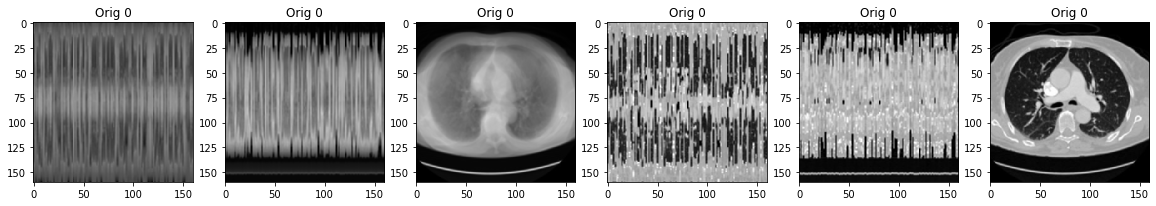

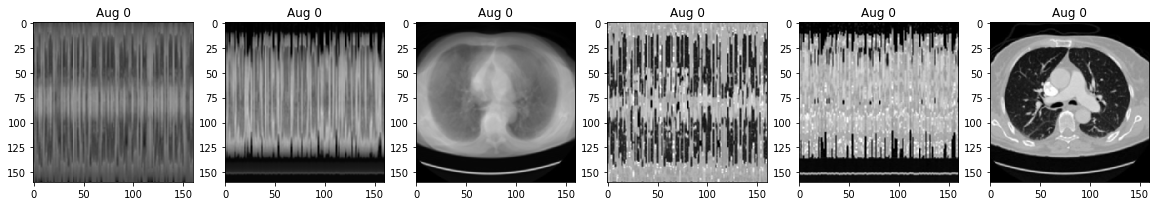

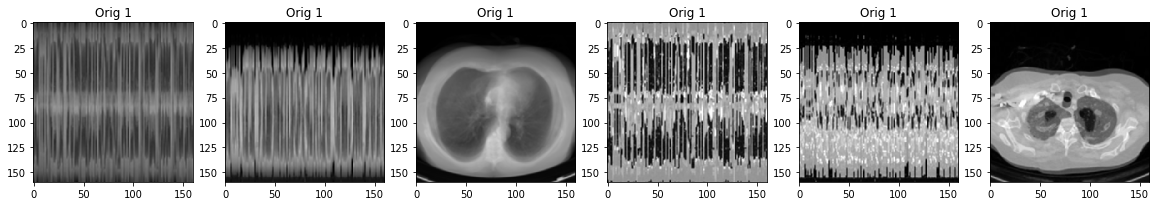

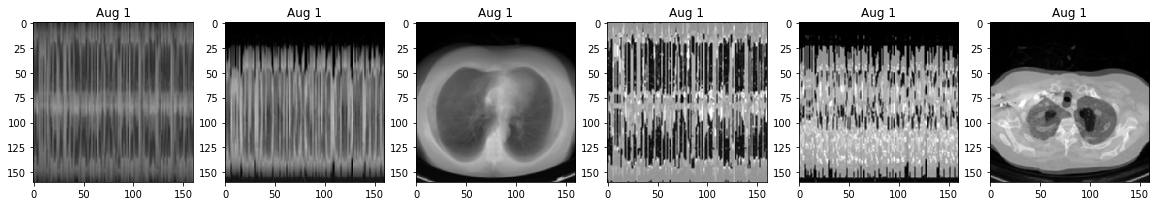

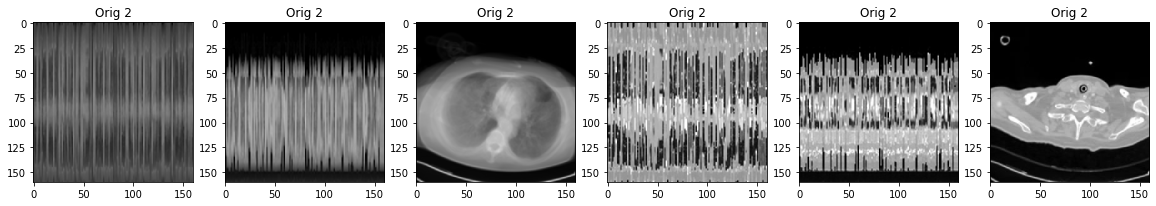

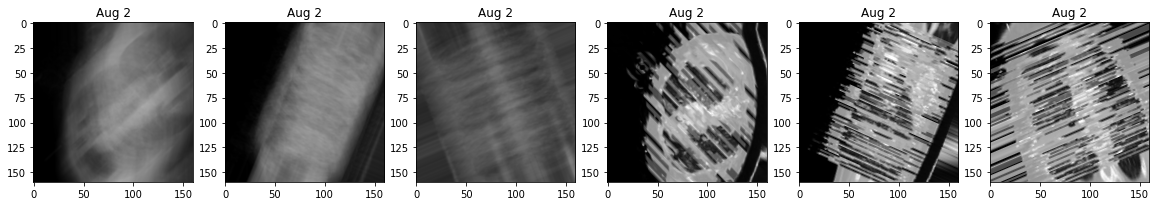

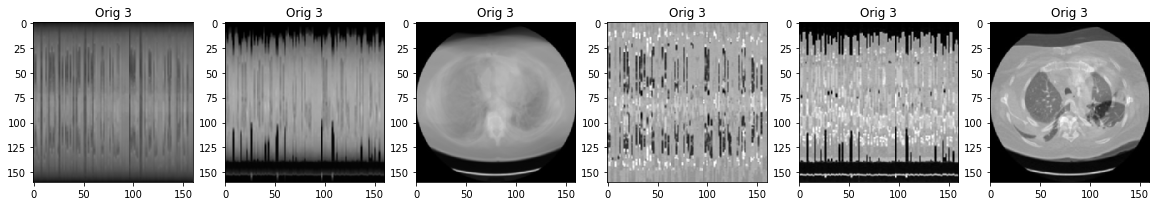

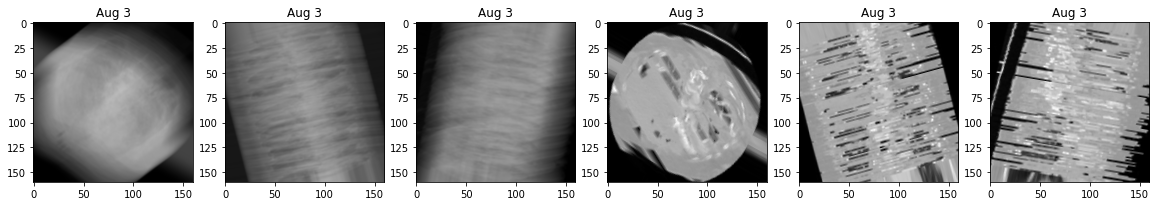

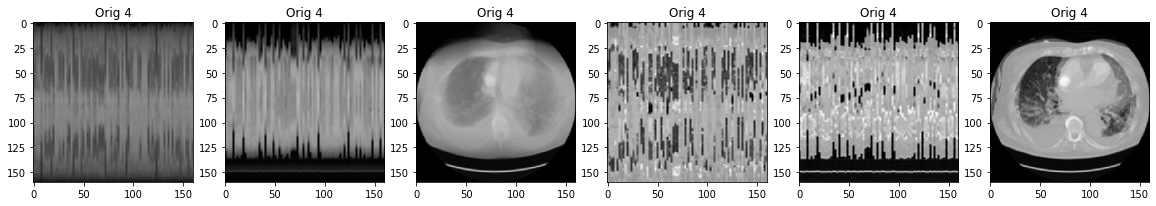

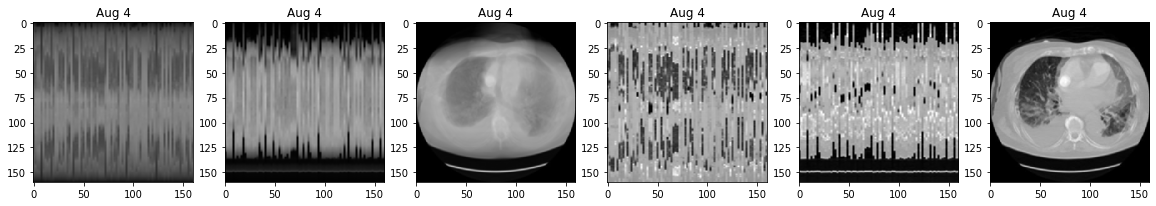

In [11]:
dataset_show = RSNADataset3D(df_study.head(5), 'train', transform=val_transforms)
dataset_show_aug = RSNADataset3D(df_study.head(5), 'train', transform=train_transforms)
from pylab import rcParams
rcParams['figure.figsize'] = 20,5
for i in range(5):
    f, axarr = plt.subplots(1,6)
    img, label = dataset_show[i]
    for j in range(6):        
        if j<=2: axarr[j].imshow(img.numpy().transpose(1,2,3,0).mean(axis=j))
        elif j==3: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[image_size//2,:,:])
        elif j==4: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[:,image_size//2,:])
        elif j==5: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[:,:,image_size//2])
        axarr[j].set_title(f"Orig {i}")
    f, axarr = plt.subplots(1,6)
    img, label = dataset_show_aug[i]    
    for j in range(6):        
        if j<=2: axarr[j].imshow(img.numpy().transpose(1,2,3,0).mean(axis=j))
        elif j==3: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[image_size//2,:,:])
        elif j==4: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[:,image_size//2,:])
        elif j==5: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[:,:,image_size//2])
        axarr[j].set_title(f"Aug {i}")
    plt.show()

In [12]:
bce = nn.BCEWithLogitsLoss()
def criterion(logits, target): 
    loss = bce(logits.view(-1), target.view(-1))
    return loss

In [13]:
def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)       
        loss = criterion(logits, target)

        if not use_amp:
            loss.backward()
        else:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()

        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(model, loader, is_ext=None, n_test=1, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)
            LOGITS.append(logits.detach().cpu())
            TARGETS.append(target.detach().cpu())

    val_loss = criterion(torch.cat(LOGITS), torch.cat(TARGETS)).numpy()
    PROBS = torch.sigmoid(torch.cat(LOGITS)).numpy().squeeze()    
    LOGITS = torch.cat(LOGITS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()
    
    if get_output:
        return LOGITS, PROBS, TARGETS
    else:
        acc = (PROBS.round() == TARGETS).mean() * 100.
        auc = roc_auc_score(TARGETS, LOGITS)
        return float(val_loss), acc, auc

In [14]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [18]:
model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=3, out_channels=out_dim).to(device)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [15]:
def run(fold):
    df_train = df_study[(df_study['fold'] != fold)]
    df_valid = df_study[(df_study['fold'] == fold)]

    dataset_train = RSNADataset3D(df_train, 'train', transform=train_transforms)
    dataset_valid = RSNADataset3D(df_valid, 'val', transform=val_transforms)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=8, sampler=RandomSampler(dataset_train), num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=8, num_workers=num_workers)

    model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=3, out_channels=out_dim).to(device)

    val_loss_best = 1000
    model_file = f'{kernel_type}_best_fold{fold}.pth'

    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    if use_amp:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
#     if len(os.environ['CUDA_VISIBLE_DEVICES'].split(',')) > 1:
#         model = nn.DataParallel(model)         
        
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        scheduler_warmup.step(epoch-1)

        train_loss = train_epoch(model, train_loader, optimizer)
        val_loss, acc, auc = val_epoch(model, valid_loader)
    
        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(val_loss):.5f}, acc: {(acc):.4f}, auc: {(auc):.6f}'
        print(content)
        with open(f'log_{kernel_type}.txt', 'a') as appender:
            appender.write(content + '\n')             
            
        if val_loss < val_loss_best:
            print('val_loss_best ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_best, val_loss))
            torch.save(model.state_dict(), model_file)
            val_loss_best = val_loss

    torch.save(model.state_dict(), f'{kernel_type}_model_fold{fold}.pth')

In [16]:
run(fold=0)

/share/pkg.7/pytorch/1.5.1/install/3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/share/pkg.7/pytorch/1.5.1/install/3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue i

493 107
Mon Nov 16 16:48:44 2020 Epoch: 1


100%|██████████| 14/14 [00:39<00:00,  2.86s/it]


Mon Nov 16 16:53:53 2020 Fold 0, Epoch 1, lr: 0.0000100, train loss: 0.66192, valid loss: 0.63177, acc: 78.5047, auc: 0.500249
val_loss_best (1000.000000 --> 0.631772).  Saving model ...


In [19]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_s